<a href="https://colab.research.google.com/github/subaru9/ml-notebooks/blob/main/cv/classification/rd-fp-planes-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model

from matplotlib import pyplot as plt

#### Fixing random seed

In [ ]:
# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

# Dataset

This is a subset of military air planes [dataset](https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset) representing russian aircrafts as well as one sample of US plane. The images cropped from the original dataset images according to the bounding box annotations and is specifically prepared to facilitate the easy training of classification models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive');

dataset_folder = "/content/drive/MyDrive/Colab Notebooks/dataset/military-air-planes"

Mounted at /content/drive


In [ ]:
if os.path.exists(dataset_folder):
    files_in_directory = os.listdir(dataset_folder)
    if files_in_directory == ['mil-planes.tar.gz']:
        os.chdir(dataset_folder)
        !tar -xzf mil-planes.tar.gz && echo "Extraction successful. Files have been unpacked."
    else:
        print("The directory contains files other than 'mil-planes.tar.gz'. Extraction skipped.")
else:
    print(f"Directory {dataset_folder} does not exist.")

The directory contains files other than 'mil-planes.tar.gz'. Extraction skipped.


## Data Inspection

In [ ]:
path = os.path.join(dataset_folder, 'mil-planes.csv')
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3384 entries, 0 to 3383
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      3384 non-null   object
 1   category  3384 non-null   object
 2   class_id  3384 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 79.4+ KB


In [ ]:
df.head()

,path,category,class_id
0,6b2f847b63922d79120334329c0ca396_1.jpg,tu95,0
1,c49d9a8f5a26485ba0bdd0fa4c32ab9b_0.jpg,tu95,0
2,953a151c55c845dfd28658f43e8d3976_0.jpg,tu95,0
3,27ee17e2c031ca3c0cf5553b6c0b52f0_1.jpg,tu95,0
4,8dcc17cbd5ec25df1c64990a6b130695_2.jpg,tu95,0


In [ ]:
df.tail()

,path,category,class_id
3379,4573b545f600572b60d2bd35fbf61a03_1.jpg,f16,7
3380,efd8a5bd1d03a71d4db28e313a3f62ce_1.jpg,f16,7
3381,f164b6193b9d4f3ecf8c8e0f234ce066_3.jpg,f16,7
3382,c7ec7b660ede88aca9a63f90ae531806_5.jpg,f16,7
3383,4fa8bb46e75938624bfc50233c29c3ff_1.jpg,f16,7


In [ ]:
df.category.unique()

array(['tu95', 'tu160', 'su57', 'su34', 'su25', 'su24', 'mig31', 'f16'],
      dtype=object)

In [ ]:
df.category.describe()

count     3384
unique       8
top        f16
freq      1366
Name: category, dtype: object

f16 is the most frequent category with almost the half of the planes, looks like dataset is imbalanced

In [ ]:
df.class_id.info(verbose=True)

<class 'pandas.core.series.Series'>
RangeIndex: 3384 entries, 0 to 3383
Series name: class_id
Non-Null Count  Dtype
--------------  -----
3384 non-null   int64
dtypes: int64(1)
memory usage: 26.6 KB


### Visualization

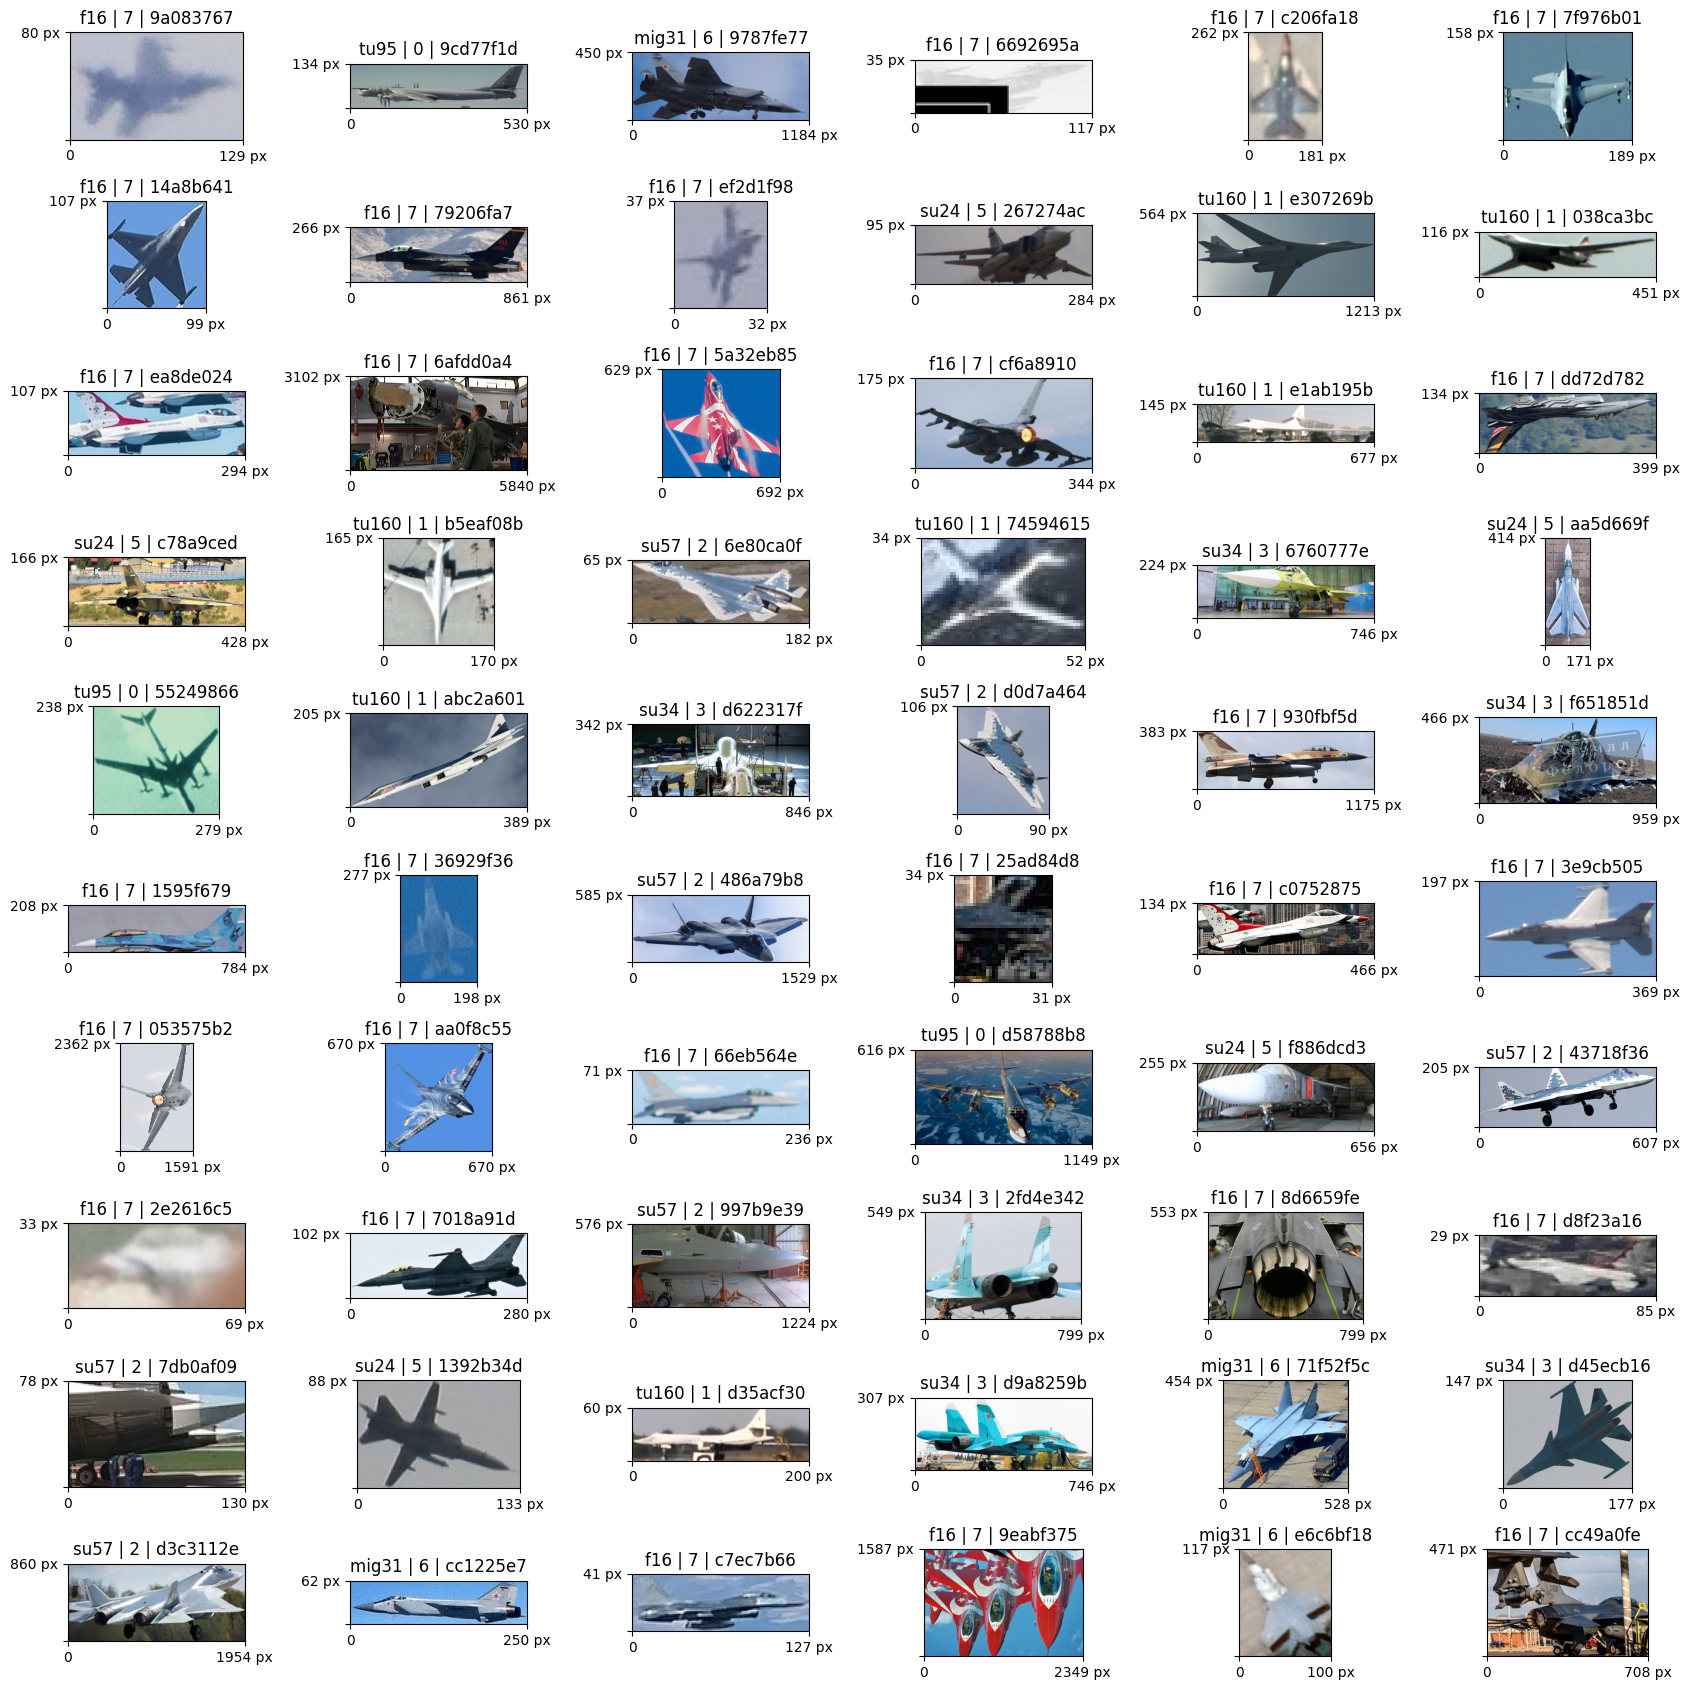

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(17, 17))

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(df))
    row = df.iloc[idx]

    class_id = row['class_id']
    class_name = row['category']
    short_filename = row['path'][:8]
    ax.set_title(f"{class_name} | {class_id} | {short_filename}")

    path = os.path.join(dataset_folder, row['path'])
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])

    # set coordinates to start from left bottom corner
    ax.set_xticks([0, img.shape[1]])
    ax.set_yticks([0, img.shape[0]])

    # set lables for axis in px
    ax.set_xticklabels(['0', f'{img.shape[1]} px'])
    ax.set_yticklabels(['', f'{img.shape[0]} px'])

plt.tight_layout()
plt.show()

Counter({'f16': 1366, 'su34': 381, 'mig31': 375, 'su57': 329, 'tu160': 278, 'tu95': 271, 'su24': 221, 'su25': 163})


(Text(0.5, 0, 'category'), Text(0, 0.5, 'count'))

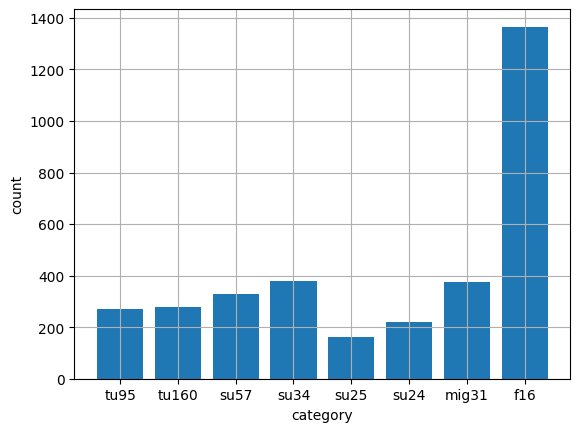

In [ ]:
from collections import Counter
hist = Counter(df['category'])
print(hist)

plt.bar(hist.keys(), hist.values()), plt.grid(True)
plt.xlabel('category'), plt.ylabel('count')

In [ ]:
# def calculate_brightness(image_path):
#     image = cv2.imread(image_path)
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     return np.mean(gray)

# brightness_per_class = {}
# class_ids = df['class_id'].unique()
# for class_id in class_ids:
#     current_class_filter = df['class_id'] == class_id
#     paths = df[current_class_filter]['path']
#     brightnesses = [calculate_brightness(os.path.join(dataset_folder, path)) for path in paths]
#     brightness_per_class[class_id] = np.mean(brightnesses)

In [ ]:
# plt.bar(brightness_per_class.keys(), brightness_per_class.values()), plt.grid(True)
# plt.xlabel('Classes ID'), plt.ylabel('Brightness')

In [ ]:
# def calculate_average_image_size(df, dataset_folder):
#     sizes = []

#     for path in df['path']:
#         image_path = os.path.join(dataset_folder, path)
#         image = cv2.imread(image_path)

#         if image is not None:
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#             sizes.append(image.shape)

#     average_height = np.mean([size[0] for size in sizes])
#     average_width = np.mean([size[1] for size in sizes])

#     return average_width, average_height

# average_width, average_height = calculate_average_image_size(df, dataset_folder)
# print(f"Average width: {average_width}, Average height: {average_height}")

## Data preparation

To address the dataset's challenges, we will implement several strategies dynamically during the training phase:

- **Adjust Image Sizes Dynamically**: Images will be resized to a uniform size in real-time during the training process, ensuring consistent input dimensions.
- **Apply Data Augmentation On-the-fly**: Various image transformations, such as rotations, scaling, and flipping, will be dynamically applied to enrich the dataset and improve the model's ability to generalize.
- **Dynamically Adjust Class Weights**: To mitigate class imbalance, class weights will be modified in real-time, prioritizing underrepresented classes during training.
- **Dynamical Image normalization**
- **Dynamic one-hot-encoding for lables**

In [ ]:
from sklearn.model_selection import train_test_split

train_valid_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, random_state=42)

print(f"Total dataset size: {df.shape[0]}")
print(f"Train dataset size: {train_df.shape[0]}")
print(f"Validation dataset size: {valid_df.shape[0]}")
print(f"Test dataset size: {test_df.shape[0]}")


Total dataset size: 3384
Train dataset size: 2030
Validation dataset size: 677
Test dataset size: 677


### Dynamically Adjust Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(train_df['class_id'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['class_id'])

class_weights = dict(zip(classes, weights))

print(class_weights)

{0: 1.7744755244755244, 1: 1.5472560975609757, 2: 1.2378048780487805, 3: 1.122787610619469, 4: 2.393867924528302, 5: 2.063008130081301, 6: 1.1481900452488687, 7: 0.30136579572446553}


### Apply strategies to address the dataset's challenges

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def randomly_apply_blur_rgb(img, probability=0.5, max_blur=5):
    """
    Args:
    img (numpy.ndarray): Input RGB image.
    probability (float): Probability of applying the blur effect.
    max_blur (int): Maximum kernel size for blurring.

    Returns:
    numpy.ndarray: The original or blurred RGB image.

    This function applies a Gaussian blur to an input RGB image with a specified probability.
    If the random condition (based on the given probability) is met,
    the image will be blurred using a Gaussian kernel with a random size up to 'max_blur'.
    The size of the blur kernel is adjusted to be an odd number to meet the requirements of the cv2.GaussianBlur function.
    If the condition is not met, the original image will be returned without any blurring effect applied.
    """
    if np.random.rand() < probability:
        blur_size = np.random.randint(1, max_blur + 1)
        # Ensure the kernel size is an odd number
        blur_size += (blur_size + 1) % 2
        img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)

    return img

train_datagen = ImageDataGenerator(
    preprocessing_function=randomly_apply_blur_rgb,
    rescale=1./255,                # Dynamical Image normalization
    rotation_range=10,             # Apply Data Augmentation On-the-fly
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.10,
    fill_mode='reflect'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=dataset_folder,
    x_col='path',
    y_col='category',
    target_size=(224, 224),         # Adjust Image Sizes Dynamically
    color_mode='rgb',
    class_mode='categorical',       # Dynamic one-hot-encoding for lables
    batch_size=32
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=dataset_folder,
    x_col='path',
    y_col='category',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_folder,
    x_col='path',
    y_col='category',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 2030 validated image filenames belonging to 8 classes.
Found 677 validated image filenames belonging to 8 classes.
Found 677 validated image filenames belonging to 8 classes.


### Network Architecture

In [ ]:
from tensorflow.keras.applications import EfficientNetB6

# Initialize the base model EfficientNetB0
base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model to prevent them from being updated during training
base_model.trainable = False

# Input layer
inputs = Input(shape=(224, 224, 3)) # EfficientNet expects 3 channels as input

# Pass the data through the base model (excluding its top layers)
x = base_model(inputs, training=False)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
outputs = Dense(8, activation='softmax')(x)

# Model assembly
model = Model(inputs, outputs)

model.summary()

165234480/165234480 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb6 (Functional  (None, 7, 7, 2304)        40960143  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2304)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2360320   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                            

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Model Training

In [ ]:
epochs = 60

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // 32,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=len(valid_df) // 32,
    class_weight=class_weights
)

Epoch 1/60
63/63 [==============================] - 172s 837ms/step - loss: 2.9388 - accuracy: 0.3589 - val_loss: 1.9238 - val_accuracy: 0.3854
Epoch 2/60
63/63 [==============================] - 47s 741ms/step - loss: 2.7659 - accuracy: 0.4014 - val_loss: 1.9021 - val_accuracy: 0.3854


KeyboardInterrupt: 

### History Visualization

In [ ]:
def plot_training_history(history, epochs_range):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Loss plot
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history, range(1, epochs + 1))